<a href="https://colab.research.google.com/github/Henil21/Intro_to_computer_vision_and_CNN/blob/main/Transfer_learning_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are two main benefits to using transfer learning:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.


2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

In [ ]:
# lets check we are using gpu or not
!nvidia-smi

Thu Dec  1 17:01:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# get data (10$ if 10 food class)
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-12-01 17:01:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 74.125.28.128, 74.125.134.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   218MB/s    in 0.7s    

2022-12-01 17:01:22 (218 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
import os
for dirpath,dirname,filenames in os.walk("10_food_classes_10_percent"):
  print(f"there are {len(dirname)} directories and {len(filenames)} images in '{dirpath}'")

there are 2 directories and 0 images in '10_food_classes_10_percent'
there are 10 directories and 0 images in '10_food_classes_10_percent/train'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_ric

## Creating loader()
we will use `ImageDataGenerator` class to load in our images in batches

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

train_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)


train_data=train_datagen.flow_from_directory(train_dir,
                                 target_size=IMAGE_SHAPE,
                                 batch_size=BATCH_SIZE,
                                 class_mode="categorical")

print("testing images:")
test_data=test_datagen.flow_from_directory(test_dir,
                                           target_size=IMAGE_SHAPE,
                                           batch_size=BATCH_SIZE,
                                           class_mode='categorical')

Found 750 images belonging to 10 classes.
testing images:
Found 2500 images belonging to 10 classes.


## Setting Up callback 🔙(things to run while our model trains)

callback are extra functionality we can add to our models to performed during or after training .some of the most popular callbacks:

* Experiment tracking with TensorBoard - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.


* Model checkpointing - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.


* Early stopping - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

In [ ]:
# create TensorBoard callback (functionized because we need to create a new model)
import datetime
import tensorflow as tf
def create_tensorboard_callback(dir_name,experiment_name):
  log_dir=dir_name+'/'+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving tfboard log file to{log_dir}")
  return  tensorboard_callback

## Create models using TesnsorFlow Hub⚜

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficien

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
# lets make a creat_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])
  print(num_classes)

  return model
  

> creating and testing ResNet tensorflow Hub feature extraction


In [ ]:
resnet_model=create_model(resnet_url,
                          num_classes=train_data.num_classes)

10


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
resnet_history=resnet_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                       experiment_name="resnet50v2")]
                                
                 )

saving tfboard log file totensorflow_hub/resnet50v2/20221201-170130
Epoch 1/5
24/24 [==============================] - 29s 751ms/step - loss: 1.7832 - accuracy: 0.4067 - val_loss: 1.1307 - val_accuracy: 0.6392
Epoch 2/5
24/24 [==============================] - 16s 681ms/step - loss: 0.8648 - accuracy: 0.7373 - val_loss: 0.8178 - val_accuracy: 0.7356
Epoch 3/5
24/24 [==============================] - 16s 677ms/step - loss: 0.5918 - accuracy: 0.8427 - val_loss: 0.7254 - val_accuracy: 0.7664
Epoch 4/5
24/24 [==============================] - 16s 676ms/step - loss: 0.4642 - accuracy: 0.8827 - val_loss: 0.6953 - val_accuracy: 0.7736
Epoch 5/5
24/24 [==============================] - 16s 683ms/step - loss: 0.3670 - accuracy: 0.9173 - val_loss: 0.6563 - val_accuracy: 0.7816


>Great!!

In [ ]:
import matplotlib.pyplot as plt
 
def plot_loss_curve(history):
   loss=history.history['loss']
   val_loss=history.history['val_loss']

   
   accuracy=history.history['accuracy']
   val_accuracy=history.history['val_accuracy']

   epochs=range(len(history.history['loss']))

   plt.plot(epochs,loss,label="training loss")
   plt.plot(epochs,val_loss,label="val_loss")
   plt.title("loss")
   plt.xlabel("epochs")
   plt.legend()
   
   plt.figure()
   plt.plot(epochs,accuracy,label="training_accuracy")
   plt.plot(epochs,val_accuracy,label="val_accuracu")
   plt.title("accuracy")
   plt.xlabel("epochs")
   plt.legend()

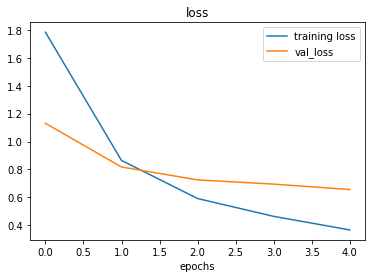

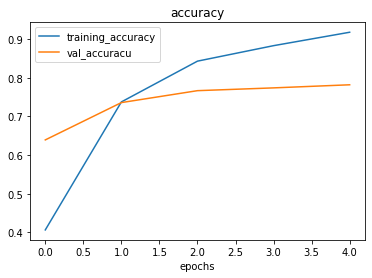

In [ ]:
plot_loss_curve(resnet_history)

## Creating and testing EfficientNetB0 Tesnsorflow Hub features Extraction model

In [ ]:
# create 
effnet_model=create_model(model_url=efficientnet_url)
effnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# fitting
effnet_history=effnet_model.fit(train_data,
                                epochs=5, 
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                       experiment_name="efficientnetb0")])

10
saving tfboard log file totensorflow_hub/efficientnetb0/20221201-170312
Epoch 1/5
24/24 [==============================] - 25s 719ms/step - loss: 1.8361 - accuracy: 0.4613 - val_loss: 1.2859 - val_accuracy: 0.7348
Epoch 2/5
24/24 [==============================] - 15s 648ms/step - loss: 1.0510 - accuracy: 0.7693 - val_loss: 0.8622 - val_accuracy: 0.8216
Epoch 3/5
24/24 [==============================] - 15s 642ms/step - loss: 0.7519 - accuracy: 0.8267 - val_loss: 0.6961 - val_accuracy: 0.8440
Epoch 4/5
24/24 [==============================] - 16s 682ms/step - loss: 0.6003 - accuracy: 0.8600 - val_loss: 0.6087 - val_accuracy: 0.8556
Epoch 5/5
24/24 [==============================] - 15s 642ms/step - loss: 0.5084 - accuracy: 0.8840 - val_loss: 0.5568 - val_accuracy: 0.8616


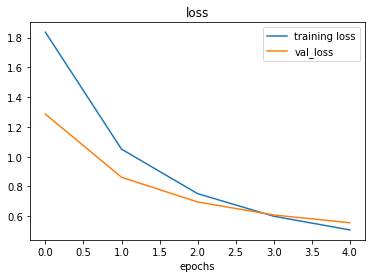

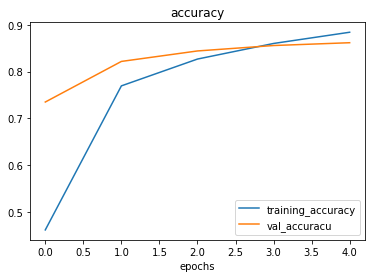

In [ ]:
plot_loss_curve(effnet_history)

In [ ]:
effnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


 ## Different types of transfer learning

* **"As is"** transfer learning - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)

* **"Feature extraction"** transfer learning use the - prelearned patterns of an existing model (e.g. EfficientNetBO trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)

* **"Fine-tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

In [ ]:
effnet_model.layers[1].weights
  

[<tf.Variable 'output_layer/kernel:0' shape=(1280, 10) dtype=float32, numpy=
 array([[-0.04778928, -0.00419774, -0.01552546, ..., -0.07450657,
         -0.00170591,  0.09713405],
        [-0.06928349, -0.05592213, -0.07335948, ...,  0.02785963,
         -0.09547085,  0.08497567],
        [ 0.02000956,  0.06455106, -0.01654305, ..., -0.01149131,
          0.02778693, -0.01930211],
        ...,
        [-0.07922643,  0.01279085, -0.06242396, ..., -0.00555097,
          0.0016941 ,  0.07176522],
        [ 0.03709626, -0.05984984, -0.09959546, ..., -0.04566087,
         -0.02288849,  0.09246288],
        [-0.0545143 , -0.02273036,  0.05867558, ...,  0.01255981,
          0.05109119,  0.08120409]], dtype=float32)>,
 <tf.Variable 'output_layer/bias:0' shape=(10,) dtype=float32, numpy=
 array([-0.00115412, -0.00704123,  0.00789076, -0.00720523,  0.0074004 ,
         0.00537948,  0.01042173,  0.00554325, -0.01323877, -0.0122742 ],
       dtype=float32)>]

## Comparing our models results using TensorBoard 
>🔑 **Note**: When you upload things to TensorBoard.dev, you experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [26]:
# # upload TensorBoard dev records
# ! tensorboard dev upload --logdir ./tensorflow_hub/ \
# --name "EfficientNetbB0 VS. ResNet50V2"\
# --description "comparing two differenty TF hub features extraction model architecture" \
# --one_shot

our experiments are uploaded here: https://tensorboard.dev/experiment/RC5nwoAiRDqKSrhOZiQ1BQ/

In [27]:
!tensorboard dev list

https://tensorboard.dev/experiment/RC5nwoAiRDqKSrhOZiQ1BQ/
	Name                 EfficientNetbB0 VS. ResNet50V2
	Description          comparing two differenty TF hub features extraction model architecture
	Id                   RC5nwoAiRDqKSrhOZiQ1BQ
	Created              2022-12-01 17:20:21 (5 minutes ago)
	Updated              2022-12-01 17:20:23 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918466
https://tensorboard.dev/experiment/w6Js7os3RTmVLU7BhXY8gw/
	Name                 EfficientNetbB0 VS. ResNet50V2
	Description          comparing two differenty TF hub features extraction model architecture
	Id                   w6Js7os3RTmVLU7BhXY8gw
	Created              2022-12-01 17:08:13 (17 minutes ago)
	Updated              2022-12-01 17:08:15 (17 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918466
https://tens

In [ ]:
# to delete an experiment 
#  !tensorboard dev delete -- experiment_id

# **Fine-Tuning🌻**
